# First pass analysis of line/loop data

<ul>
    <li> Analyse correct sequence lengths. </li>
    <li> Do reaction times </li>
    <li> Analyse as a function of distance from reward </li>
    <li> Try to fit RL model to these data </li> 
    
</ul>

<b> WHY IS THERE A DIFFERENCE BETWEEN REW_LIST AND DAT_DICT['STATE'] </b>

In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn
import scipy.stats as stt
seaborn.set(font_scale=1.5,style='ticks')
import os
import re
import sys
import itertools
import functools
import networkx as nx
from datetime import date, timedelta
from datetime import datetime

seaborn.set(font_scale=1.5,style='ticks',rc={'axes.edgecolor': 'k',
                                             'axes.linewidth': 2,
                                             #'xtick.major.size': 6,
                                             'axes.labelcolor':'k',
                                             'xtick.major.width': 2,
                                             'ytick.major.width': 2,
                                             'xtick.major.pad': 5.5,
                                             'ytick.major.pad': 5.5,
                                             'axes.labelsize': 18
                                            })


sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master")
sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master\packages")
sys.path.append("/Users/yves/Documents/Code/line_loop/packages/")

In [4]:
import mouse_poker as mpk
from mouse_poker.navi import *

# Defined functions 

In [5]:
poke_pos = [ [149,0],
         [68,19],[231,19],
       [0,62],[149,62],[298,62],
         [68,105],[231,105],
              [149,124]]

In [191]:
def get_transitions(state_seq,rew_list,port_seq,forced_seq,rew_indices,map_poke_to_state,minNrew=5,set_rew_indices=None,firstOnly=False):
    """ This function obtains empirical counts for transitions from a given state to another
        as a function of """
    used_states = sorted([i[1] for i in map_poke_to_state.args[0]])
    if set_rew_indices is None: set_rew_indices=used_states
    perf = np.zeros([9,9,9])
    perf_ctr = np.zeros([9,9,9])
    rew_hist = []
    transition_mtx = np.zeros([9,9,9])
    state_ctr = np.zeros([9,9])
    all_rew_loc = []
    for rew_ctr,(st,nd) in enumerate(zip(np.where(rew_list)[0][:-2],np.where(rew_list)[0][1:-1])):
        rew_loc = state_seq[nd]
        if (rew_loc in set_rew_indices):
            c_rew_index = rew_indices.index(port_seq[nd])
            all_rew_loc.append(rew_loc)
            if not rew_hist:
                rew_hist.append(rew_loc)
            elif rew_loc==rew_hist[-1]:
                rew_hist.append(rew_loc)
            else:
                rew_hist = []

            has_visited= []
            if len(rew_hist)>minNrew:

                for pk_ctr in range(st+1,nd+1):
                    if not forced_seq[pk_ctr]:
                        state = state_seq[pk_ctr]
                        if state not in has_visited:

                            next_state = state_seq[pk_ctr+1]

                            transition_mtx[state,next_state,rew_loc] += 1
                            state_ctr[state,rew_loc] += 1
                            if firstOnly: has_visited.append(state)

    
    return transition_mtx, state_ctr, np.unique(all_rew_loc)

In [192]:
def run_transition_perf_analysis(lines,minNrew=0,set_rew_indices=None,firstOnly=False):
    """ """
    experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
    #dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)
    state_seq, rew_list, port_seq,forced_seq = extract_navi_dat(lines)
    poke_to_state_map,full_pkst_map = get_poke_to_state_map(lines)
    used_states = sorted([i[1] for i in full_pkst_map])
    used_pokes = ([i[0] for i in full_pkst_map])

    map_poke_to_state = functools.partial(map_poke_to_state_fun,full_pkst_map)
    map_state_to_poke = functools.partial(map_state_to_poke_fun,full_pkst_map)

    #rew_indices = [0,3,5,8]
    rew_indices = np.unique([eval(re.findall('REWARD LOCATIONS(\[.*\])',l)[0]) for l in lines if re.findall('REWARD LOCATIONS(\[.*\])',l)][0]).tolist()
    
    
    transition_mtx,ctr,rew_indices_state = get_transitions(state_seq,
                                                        rew_list,
                                                        port_seq,
                                                        forced_seq,
                                                        rew_indices,
                                                        map_poke_to_state,
                                                        minNrew=minNrew,
                                                        set_rew_indices=set_rew_indices,
                                                        firstOnly=firstOnly)

  
    
    if set_rew_indices is None:
        to_ret = np.array([(transition_mtx/ctr[:,None])[:,:,i]
                           for i in range(9)])
        ret_ctr = np.array([ctr[:,i] for i in range(9)])
        ret_dirs = np.array([transition_mtx[:,:,i] for i in range(9)])

    else:
        to_ret = np.array([(transition_mtx/ctr[:,None])[:,:,i]
                           for i in set_rew_indices])  #this is the empirical transition matrix
        
        ret_ctr = np.array([ctr[:,i] for i in set_rew_indices])
        ret_dirs = np.array([transition_mtx[:,:,i] for i in set_rew_indices])
     
   
        
    return to_ret, rew_indices_state, used_states, ret_ctr, ret_dirs

In [201]:
#f = "C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI_males/'456674_1'-2021-03-15-114101.txt"
#f = "C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI_males/'456674_1'-2021-03-15-143737.txt"
f = "C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI/'456675_10'-2021-03-15-145534.txt"
lines = open(f,'r').readlines()


In [202]:
experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)

dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)

poke_to_state_map,full_pkst_map = get_poke_to_state_map(lines)
used_states = sorted([i[1] for i in full_pkst_map])
used_pokes = ([i[0] for i in full_pkst_map])

map_poke_to_state = functools.partial(map_poke_to_state_fun,full_pkst_map)
map_state_to_poke = functools.partial(map_state_to_poke_fun,full_pkst_map)
rew_indices = np.unique([eval(re.findall('REWARD LOCATIONS(\[.*\])',l)[0]) for l in lines if re.findall('REWARD LOCATIONS(\[.*\])',l)][0]).tolist()


#transition_mtx,ctr = get_transitions(dat_dict,map_poke_to_state,rew_indices,lines,minNrew=0)
transition_mtx,rew_indices_state,used_states,_,_ = run_transition_perf_analysis(lines)
used_states = np.array(used_states)

<ipython-input-192-661a25ce5437>:30: RuntimeWarning: invalid value encountered in true_divide
  to_ret = np.array([(transition_mtx/ctr[:,None])[:,:,i]


In [203]:
print(nRews,task_nr)

411 2


In [204]:
lines = open(f,'r').readlines()
experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)

dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)

poke_to_state_map,full_pkst_map = get_poke_to_state_map(lines)
used_states = sorted([i[1] for i in full_pkst_map])
used_pokes = ([i[0] for i in full_pkst_map])

map_poke_to_state = functools.partial(map_poke_to_state_fun,full_pkst_map)
map_state_to_poke = functools.partial(map_state_to_poke_fun,full_pkst_map)
rew_indices = np.unique([eval(re.findall('REWARD LOCATIONS(\[.*\])',l)[0]) for l in lines if re.findall('REWARD LOCATIONS(\[.*\])',l)][0]).tolist()


#transition_mtx,ctr = get_transitions(dat_dict,map_poke_to_state,rew_indices,lines,minNrew=0)
transition_mtx,rew_indices_state,used_states,_,_ = run_transition_perf_analysis(lines,minNrew=1)
used_states = np.array(used_states)

<ipython-input-192-661a25ce5437>:30: RuntimeWarning: invalid value encountered in true_divide
  to_ret = np.array([(transition_mtx/ctr[:,None])[:,:,i]


In [205]:
tmtx_short = np.array([transition_mtx[ix] for ix,sm in enumerate(np.nansum(transition_mtx,axis=(1,2))) if sm>2])

In [206]:
transition_mtx[6]

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.4375    , 0.        ,
        0.5625    , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.20338983, 0.08474576,
        0.20338983, 0.        , 0.27118644, 0.23728814],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.65909091, 0.        , 0.34090909],


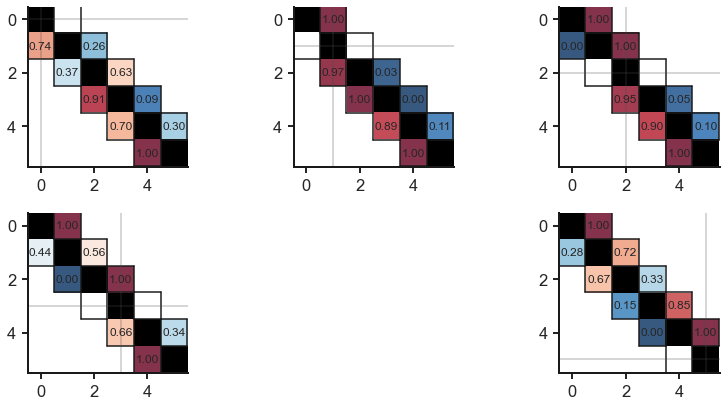

In [207]:
plt.figure(figsize=(12,6))
ctr = 1
for ix in range(tmtx_short.shape[0]):
    plt.subplot(2,3,ctr)
    draw_transition_matrix(tmtx_short,ix,used_states,rew_indices_state)
    ctr += 1

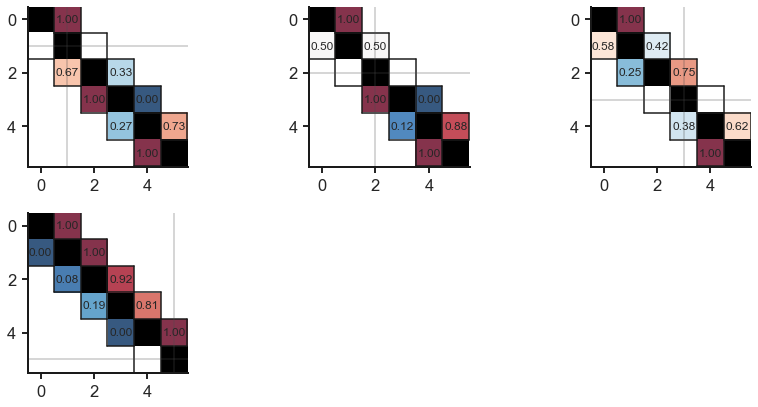

In [200]:
plt.figure(figsize=(12,6))
ctr = 1
for ix in range(tmtx_short.shape[0]):
    plt.subplot(2,3,ctr)
    draw_transition_matrix(tmtx_short,ix,used_states,rew_indices_state)
    ctr += 1

In [123]:
def draw_transition_matrix(transition_mtx,ix_,used_states,rew_indices,graph_type='line',verbose=False):
    im = transition_mtx[ix_].copy()[used_states[:,None],used_states[None,:]]
    plt.imshow(np.dstack([np.eye(im.shape[0])*-1 + 1]*3 + [np.eye(im.shape[0])]),cmap='Greys')
    for i in range(len(used_states)-1):
        plt.plot([i+.5,i+1.5],[i-.5,i-.5],color='k')
        plt.plot([i+.5,i+1.5],[i+.5,i+.5],color='k')
        plt.plot([i-.5,i-.5],[i+.5,i+1.5],color='k')
        plt.plot([i+.5,i+.5],[i+.5,i+1.5],color='k')
        plt.plot([i+.5,i+.5],[i-.5,i+.5],color='k')
        plt.plot([i-.5,i+.5],[i+1.5,i+1.5],color='k')
        plt.plot([i+1.5,i+1.5],[i-.5,i+.5],color='k')

    if graph_type=='loop':
        plt.plot([-.5,.5],[4.5,4.5],color='k')
        plt.plot([.5,.5],[4.5,5.5],color='k')
        
        plt.plot([4.5,4.5],[-.5,.5],color='k')
        plt.plot([4.5,5.5],[-.5,-.5],color='k')
        plt.plot([4.5,5.5],[.5,.5],color='k')
        plt.plot([5.5,5.5],[-.5,.5],color='k')

    rloc = rew_indices[ix_]
    #for ix_ in range(transition_mtx.shape[0]):
    #im[np.logical_not(np.nansum(transition_mtx,axis=0)[used_states[:,None],used_states[None,:]]>0)] = np.nan
    tmp_im = np.ones_like(im)*np.nan
    #np.fill_diagonal(tmp_im,1)
    np.fill_diagonal(tmp_im[1:], 1)
    np.fill_diagonal(tmp_im[:,1:], 1)
    if lineloop=='loop': tmp_im[0,-1] = 1; tmp_im[-1,0] = 1
    
    tmp_im[rew_indices_state[ix_]-used_states[0],:] = np.nan
    #tmp_im[rew_indices_state[ix_]-used_states[0],rew_indices_state[ix_]-used_states[0]+1] = np.nan
    
    im = im*tmp_im
    if graph_type=='line':
        im[0,-1] = np.nan; im[-1,0] = np.nan
        if (rew_indices[ix_]-used_states[0])!=0:
            im[0,1] = 1;
        if (rew_indices[ix_]-used_states[0])!=5:
            im[-1,-2] = 1
    #plt.xticks(np.arange(centers[0], centers[1]+dx, dx))
    #ax = plt.gca()
    plt.imshow(im,cmap='RdBu_r',alpha=.8,interpolation='None',vmin=0,vmax=1)
    #plt.colorbar()

    #plt.xticks(plt.xticks()[0],plt.xticks()[0]-.5) 
    #plt.yticks(plt.yticks()[0],plt.yticks()[0]-.5)
    #plt.scatter([rew_indices_state[ix_]-used_states[0]]*im.shape[0],np.arange(im.shape[0]),marker='*',color='k',s=96)
    if verbose:
        plt.gca().text(4,rew_indices_state[ix_]-used_states[0]-.15,'rewarded state',ha='center',va='center',fontsize=12,color='k')

    plt.plot([-.5,im.shape[1]+.5],2*[rew_indices_state[ix_]-used_states[0]],color='.3',alpha=.3)
    plt.plot(2*[rew_indices_state[ix_]-used_states[0]],[-.5,im.shape[1]+.5],color='.3',alpha=.3)
    plt.xlim(-.475,im.shape[0]-.475)
    plt.ylim(im.shape[0]-.475,-.475)

    for (j,i),label in np.ndenumerate(im):
        if not np.isnan(label):
            plt.gca().text(i,j,'{:.2f}'.format(label),ha='center',va='center',fontsize=12)
        #ax2.text(i,j,label,ha='center',va='center')
    plt.tight_layout()
    #plt.ylim(6.5,.5)
    #plt.xlim(.5,6.5)
    seaborn.despine()

In [124]:
#draw_transition_matrix(transition_mtx,0,used_states,rew_indices)

# Actual code to run stuff 

In [168]:
#ROOT_loop = '/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI_toLOOP//'
#ROOT_line = '/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI///'

ROOT_line = "C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI/"
ROOT_loop = "C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI_toLOOP/"

#\


In [208]:
fdict = {}
now = datetime.now()
for ROOT,lineloop in zip([ROOT_line,ROOT_loop],['line','loop']):
    fs = [i for i in os.listdir(ROOT) if os.path.isfile(os.path.join(ROOT,i))]
    for f in fs:
        f = os.path.join(ROOT,f)

        subject = re.findall("'(.*)'",f)
        t1_ = re.findall(r'(202.*)-[0-9]{6}.txt',f)[0]
        t1_ = datetime.strptime(t1_,'%Y-%m-%d')

        #if ('03-04' in f) or ('03-05' in f) or ('03-02' in f):
        #if ('03-05' in f):
        if (now - t1_).days<=12:
            if subject: 
                lines =open(f,'r').readlines()

                subject = subject[0]
                experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
                dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)
            
                if nRews>20 and task_nr=='2':
                    print(f)
                    if subject+lineloop in fdict.keys():
                        fdict[subject+lineloop].append(f)
                    else:
                        fdict[subject+lineloop] = [f]



C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI/'456675_10'-2021-03-03-105405.txt
C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI/'456675_10'-2021-03-15-143847.txt
C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI/'456675_10'-2021-03-15-145534.txt
C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI/'460175_10'-2021-03-03-105405.txt
C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI/'460175_10'-2021-03-15-143847.txt
C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI/'460175_10'-2021-03-15-145534.txt
C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI_toLOOP/'456675_10'-2021-03-15-114001.txt
C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI_toLOOP/'460175_10'-2021-03-15-114001.txt


In [209]:
set_rew_indices = [1,3,5]
transition_res = {}
for subject in fdict.keys():

    for f in fdict[subject]:
        print(f)
        lines = open(f,'r').readlines()
        experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
        #print(task_nr)

        poke_to_state_map,full_pkst_map = get_poke_to_state_map(lines)
        used_states = sorted([i[1] for i in full_pkst_map])
        used_pokes = ([i[0] for i in full_pkst_map])

        map_poke_to_state = functools.partial(map_poke_to_state_fun,full_pkst_map)
        map_state_to_poke = functools.partial(map_state_to_poke_fun,full_pkst_map)
        rew_indices = np.unique([eval(re.findall('REWARD LOCATIONS(\[.*\])',l)[0]) for l in lines if re.findall('REWARD LOCATIONS(\[.*\])',l)][0]).tolist()

        outRes_ = run_transition_perf_analysis(lines,set_rew_indices=set_rew_indices,minNrew=3,firstOnly=False)
        tmtx,rew_indices_state,used_state,ret_ctr,t_unNorm = outRes_
        #to_ret, rew_indices_state, used_states, ret_ctr, ret_dirs
        if all([i in rew_indices_state for i in set_rew_indices]):  #only if all necessary rewards are present
            if subject in transition_res.keys():
                transition_res[subject].append(tmtx)
                transition_res[subject+'tc'].append(ret_ctr)
                transition_res[subject+'tUn'].append(t_unNorm)
                #transition_res[subject+'ri'].append(rew_indices_state)
                #transition_res[subject+'us'].append(used_states)

            else:
                transition_res[subject] = [tmtx]          #transition matrix
                transition_res[subject+'tc'] = [ret_ctr]  #total counts for each transition
                transition_res[subject+'tUn'] = [t_unNorm]  #transition matrix with counts
                transition_res[subject+'ri'] = rew_indices_state  
                transition_res[subject+'us'] = used_states

C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI/'456675_10'-2021-03-03-105405.txt
C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI/'456675_10'-2021-03-15-143847.txt
C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI/'456675_10'-2021-03-15-145534.txt


<ipython-input-192-661a25ce5437>:36: RuntimeWarning: invalid value encountered in true_divide
  to_ret = np.array([(transition_mtx/ctr[:,None])[:,:,i]


C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI/'460175_10'-2021-03-03-105405.txt
C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI/'460175_10'-2021-03-15-143847.txt
C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI/'460175_10'-2021-03-15-145534.txt
C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI_toLOOP/'456675_10'-2021-03-15-114001.txt
C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI_toLOOP/'460175_10'-2021-03-15-114001.txt


KeyError: '456675_10loop'

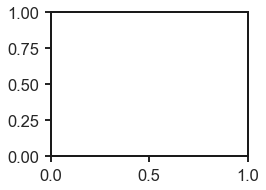

In [210]:
plt.figure(figsize=(12,9))
baseS = '456675_10'
#baseS= '460175_10'
subject = baseS+'loop'
for ctr in range(3):
    plt.subplot(3,3,ctr+1)
    
    draw_transition_matrix(np.nanmean(np.array(transition_res[subject]),axis=0),
                           ctr,
                           used_states=np.array(transition_res[subject+'us']),
                           rew_indices=np.array(transition_res[subject+'ri']),graph_type='loop')
    if ctr==0:
        plt.xlabel("State (t+1)")
        plt.ylabel("State (t)")
subject = baseS+'line'
for ctr in range(3):
    plt.subplot(3,3,ctr+1+3)
    #print(ctr+1+3)
    #print(np.nansum(np.nanmean(np.array(transition_res[subject]),axis=0)[ctr]))
    draw_transition_matrix(np.nanmean(np.array(transition_res[subject]),axis=0),
                           ctr,
                           used_states=np.array(transition_res[subject+'us']),
                           rew_indices=np.array(transition_res[subject+'ri']),graph_type='line')
plt.tight_layout()

KeyError: '460175_10loop'

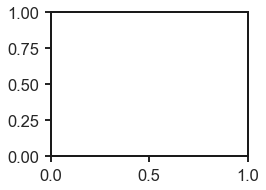

In [211]:
plt.figure(figsize=(12,9))
#baseS = '456675_10'
baseS= '460175_10'
subject = baseS+'loop'
for ctr in range(3):
    plt.subplot(3,3,ctr+1)
    
    draw_transition_matrix(np.nanmean(np.array(transition_res[subject]),axis=0),
                           ctr,
                           used_states=np.array(transition_res[subject+'us']),
                           rew_indices=np.array(transition_res[subject+'ri']),graph_type='loop',verbose=ctr==0)
    if ctr==0:
        plt.xlabel("State (t+1)")
        plt.ylabel("State (t)")

subject = baseS+'line'
for ctr in range(3):
    plt.subplot(3,3,ctr+1+3)
    #print(ctr+1+3)
    #print(np.nansum(np.nanmean(np.array(transition_res[subject]),axis=0)[ctr]))
    draw_transition_matrix(np.nanmean(np.array(transition_res[subject]),axis=0),
                           ctr,
                           used_states=np.array(transition_res[subject+'us']),
                           rew_indices=np.array(transition_res[subject+'ri']))

cbar = plt.colorbar()
cbar.set_label("Transition probability")
cbar.set_ticks([0,.5,1])
#ca


In [16]:
#cbar.minorticks_off()

# Transition matrix analysis

now based on transition matrix define a line-loop adaptation index
the harsh measure, again is if they are above chance on each transition.
You could also think of making a measure whereby you ask if it adapts from conditions
with a given optimal policy. I think this is a nice way of incorporating biases into it
because these should be constant. 

The extreme case would be to decode the condition



In [17]:
def compare_line_rew_loc(transition_res,subject):

    """ Here compare for each state transitions and ask if the behaviour is different when best
        behaviour is different between the two conditions
        
        !!!!!!! ---- This needs to be extended to ask whether the changes are going in the correct direction, 
                    not just different ---- DONE I THINK!!!!!!!
    """
    from scipy.stats import fisher_exact

    #baseS= '460175_10'
    #baseS = '456675_10'

    #subject = baseS+'line'
    
    rew_indices_state = transition_res[subject+'ri']
    used_states = transition_res[subject+'us']
    transition_mtxs = np.nansum(transition_res[subject+'tUn'],axis=0)
    nStates = len(used_states)
    res_dict = {}
    for state in used_states:

        move_up = []; move_down = []
        for rix,rloc in enumerate(rew_indices_state):
            if rloc<state:
                move_down.append(rix)
            elif rloc>state:
                move_up.append(rix)

        if move_up and move_down:
            up_sum = np.nansum([transition_mtxs[i][state] for i in move_up],axis=0)
            down_sum = np.nansum([transition_mtxs[i][state] for i in move_down],axis=0)


            table = np.array([[up_sum[state-1],up_sum[state+1]],
                             [down_sum[state-1],down_sum[state+1]]])

            test = fisher_exact(table,alternative='less')  #'less' this was just heuristically determined
            res_dict['state_'+str(state)] = {'pval':test[1],
                                             #'odds-ratio': test[0],
                                             'rel_state': state-used_states[0],
                                             'tot': table.sum(axis=0)}
            #print(fisher_exact(table)[1],state-used_states[0],np.sum(table),state)


    return res_dict

In [18]:
baseS = '456675_10'
#baseS= '460175_10'
subject = baseS+'line'

ll_res = compare_line_rew_loc(transition_res,subject)
for i in ll_res.items(): print(i)

('state_2', {'pval': 5.777311182090352e-20, 'rel_state': 1, 'tot': array([101., 197.])})
('state_3', {'pval': 0.001826658885555821, 'rel_state': 2, 'tot': array([167., 137.])})
('state_4', {'pval': 2.796571785736423e-21, 'rel_state': 3, 'tot': array([127., 123.])})


In [19]:
#baseS = '456675_10'
baseS= '460175_10'
subject = baseS+'line'

ll_res = compare_line_rew_loc(transition_res,subject)
for i in ll_res.items(): print(i)

('state_2', {'pval': 4.204164508191597e-19, 'rel_state': 1, 'tot': array([ 91., 125.])})
('state_3', {'pval': 0.045716714981232816, 'rel_state': 2, 'tot': array([120.,  91.])})
('state_4', {'pval': 3.990627678227244e-17, 'rel_state': 3, 'tot': array([103., 115.])})


In [27]:
def get_modulo_distance(rloc,state,nStates=6):
    
    return np.min(np.abs([rloc-state,rloc-(state+nStates),rloc-(state-nStates)]))

In [467]:
#get_modulo_distance(0,4)

In [468]:
#you want to compare all the cases in the line where 

In [470]:
def get_dists_line_loop(state_,rloc,nStates):
     dists_loop = []
    for s2 in [(state_-1)%nStates,(state_+1)%nStates]:
        dists_loop.append(get_modulo_distance(rloc,s2))
        
        
    dists_line = []
    for s2 in [(state_-1),(state_+1)]:
        if s2<used_states[0]: dists_line.append(100)
        elif s2>used_states[-1]: dists_line.append(100)
        else: dists_line.append(np.abs(s2-rloc))
            
    return dists_line, dists_loop

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 3)

In [ ]:
#def compare_line_with_loop 

"""
The simplest way of doing it would be to say when the reward location is
the same between the two conditions, but the required policy is different.
I think you could also do the intersection though, to get more data and 
simplify the analysis.

The logic is we look at each state. Then for each state we look, separarately
for the line and the loop, at the available next states and the distances from
there to each reward location. Then we 

What you want to do is for each state when there is a sifference between the line and the loop,.

The question is whether you can lump reward locations? I think the answer is yes.


What you want to do is for each reward location to select all of the points on the blinds.

For each state, get reward locations where move up on loop and down on line (and vice versa?)
"""




from scipy.stats import fisher_exact

#baseS= '460175_10'
baseS = '456675_10'

subject = baseS+'line'
subject_f = lambda subj,gtyp: subj+gtype

rew_indices_state = transition_res[subject+'ri']
used_states = sorted(transition_res[subject+'us'])
transition_mtxs = np.nansum(transition_res[subject+'tUn'],axis=0)

res_dict = {}

nStates = len(used_states)
for state in used_states:
    
    state_ = state_ - used_states[0]
    
    
    move_up_line = []; move_up_loop = []
    move_down_line = []; move_down_loop = []
    for rix,rloc in enumerate(rew_indices_state):

        #
        dists_line,dists_loop = get_dists_line_loop(state_,rloc,nStates)
        
        
        if np.min(dists_line)!=np.min(dists_loop):
            if np.argmin(dists_line)>np.argmin(dists_loop):  #if there is a difference between line and loop, include
            elif np.argmin(dists_line)<np.argmin(dists_loop): 


            if np.argmin(dists_loop)==0: move_down_loop.append(rix)
            else: move_up_loop.append(rix)


            if np.argmin(dists_loop)==0: move_down_loop.append(rix)
            else: move_up_loop.append(rix)

        dists_line = []
        for s2
        move_up = []; move_down = []
        for rix,rloc in enumerate(rew_indices_state):
            if rloc<state:
                move_down.append(rix)
            elif rloc>state:
                move_up.append(rix)

        if move_up and move_down:
            up_sum = np.nansum([transition_mtxs[i][state] for i in move_up],axis=0)
            down_sum = np.nansum([transition_mtxs[i][state] for i in move_down],axis=0)


            table = np.array([[up_sum[state-1],up_sum[state+1]],
                             [down_sum[state-1],down_sum[state+1]]])

            test = fisher_exact(table)
            res_dict['state'+str(state)] = {'pval':test[1],'odds-ratio': test[0],'abs_state': state-used_states[0]}
            print(fisher_exact(table)[1],state-used_states[0],np.sum(table),state)